# Regression Case Study - The Red Wine Dataset

### 1. Sourcing and loading

#### 1a. Import relevant libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm # for statistical modeling, hypothesis testing, and regression analysis
from statsmodels.graphics.api import abline_plot # adds a straight (regression) line to a plot.
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings # For handling error messages.

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#### 1b. Load the data

In [2]:
# Load the data. set the parameter index_col to 0, because the first column contains no useful data. 
wine = pd.read_csv("wineQualityReds.csv", index_col=0)

#### 1c. Exploring the data

In [3]:
wine.head(10)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
7,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
8,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
9,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
10,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
# Another very useful method to call on a recently imported dataset is .info(). Call it here to get a good
# overview of the data
wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1599 entries, 1 to 1599
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         1599 non-null   float64
 1   volatile.acidity      1599 non-null   float64
 2   citric.acid           1599 non-null   float64
 3   residual.sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free.sulfur.dioxide   1599 non-null   float64
 6   total.sulfur.dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 162.4 KB


All variables are numeric.
The 11 continuous features can be used as predictors.
The target quality is suitable for regression if treated as continuous,
or for classification if grouped into quality categories.

In [5]:
# We should also look more closely at the dimensions of the dataset. 
print("There are:", wine.shape[0], 'rows.')
print("There are:", wine.shape[1], 'columns.')

There are: 1599 rows.
There are: 12 columns.


#### 1d. Choosing a dependent variable

We now need to pick a dependent variable for our regression analysis: a variable whose values we will predict. 

'Quality' seems to be as good a candidate as any. Let's check it out. One of the quickest and most informative ways to understand a variable is to make a histogram of it. This gives us an idea of both the center and spread of its values. 

array([[<Axes: title={'center': 'quality'}>]], dtype=object)

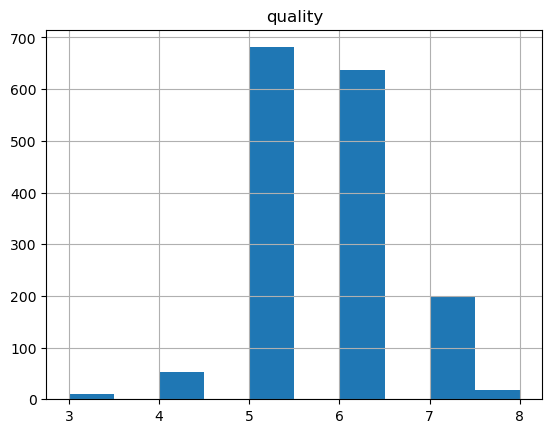

In [6]:
# Making a histogram of the quality variable.
wine.hist(column="quality")

Most wines have a quality score around 5 or 6 — that’s where the bars are highest.
The minimum quality is around 3, and the maximum is around 8.
So the range ≈ 8 − 3 = 5.


Although quality is numeric, it’s discrete (integer) — you can’t have a wine with quality = 5.37, only whole numbers (3, 4, 5, …).
Regression analysis (like linear regression) assumes the dependent variable is continuous, meaning it can take any real value.
In this case:
The quality scores are limited to integer values, not a continuous scale.
The relationship between predictors (like acidity, alcohol) and quality might not be linear.
The predicted values from regression could be fractional (like 5.42), which don’t make sense as “half a quality point.”

Because quality is discrete and ordinal, a better approach would be:
Classification modeling (e.g., logistic regression, random forest classifier),
where each integer quality level is treated as a category or class.
Or combine levels into broader categories like:
3–5 → “low quality”
6 → “medium quality”
7–8 → “high quality”
Then you can build a classification model to predict these categories.

In [7]:
# A great way to get a basic statistical summary of a variable is to call the describe() method on the relevant field. 
wine["quality"].describe()


count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [9]:
# Get a list of the values of the quality variable, and the number of occurrences of each. 
wine['quality'].value_counts(dropna=False)

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

The outputs of the describe() and value_counts() methods are consistent with our histogram, and since there are just as many values as there are rows in the dataset, we can infer that there are no NAs for the quality variable. 

But scroll up again to when we called info() on our wine dataset. We could have seen there, already, that the quality variable had int64 as its type. As a result, we had sufficient information, already, to know that the quality variable was not appropriate for regression analysis. 

The quality variable would, however, conduce to proper classification analysis. This is because, while the values for the quality variable are numeric, those numeric discrete values represent *categories*; and the prediction of category-placement is most often best done by classification algorithms. You saw the decision tree output by running a classification algorithm on the Titanic dataset on p.168 of Chapter 6 of *AoS*. For now, we'll continue with our regression analysis, and continue our search for a suitable dependent variable. 

Now, since the rest of the variables of our wine dataset are continuous, we could — in theory — pick any of them. But that does not mean that are all equally sutiable choices. What counts as a suitable dependent variable for regression analysis is determined not just by *intrinsic* features of the dataset (such as data types, number of NAs etc) but by *extrinsic* features, such as, simply, which variables are the most interesting or useful to predict, given our aims and values in the context we're in. Almost always, we can only determine which variables are sensible choices for dependent variables with some **domain knowledge**. 

Not all of you might be wine buffs, but one very important and interesting quality in wine is [acidity](https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity). As the Waterhouse Lab at the University of California explains, 'acids impart the sourness or tartness that is a fundamental feature in wine taste.  Wines lacking in acid are "flat." Chemically the acids influence titrable acidity which affects taste and pH which affects  color, stability to oxidation, and consequantly the overall lifespan of a wine.'

If we cannot predict quality, then it seems like **fixed acidity** might be a great option for a dependent variable. Let's go for that.

So if we're going for fixed acidity as our dependent variable, what we now want to get is an idea of *which variables are related interestingly to that dependent variable*. 

We can call the .corr() method on our wine data to look at all the correlations between our variables. The default correlation coefficient is the Pearson correlation coefficient; but other coefficients can be plugged in as parameters. Remember, the Pearson correlation coefficient shows us how close to a straight line the data-points fall, and is a number between -1 and 1. 

In [10]:
# Call the .corr() method on the wine dataset 
wine.corr()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
fixed.acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile.acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric.acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual.sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free.sulfur.dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total.sulfur.dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


### 2. Cleaning, Transforming, and Visualizing 

#### 2a. Visualizing correlations 
The heading of this stage of the data science pipeline ('Cleaning, Transforming, and Visualizing') doesn't imply that we have to do all of those operations in *that order*. Sometimes (and this is a case in point) our data is already relatively clean, and the priority is to do some visualization. Normally, however, our data is less sterile, and we have to do some cleaning and transforming first prior to visualizing. 

Now that we've chosen **fixed acidity** as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.

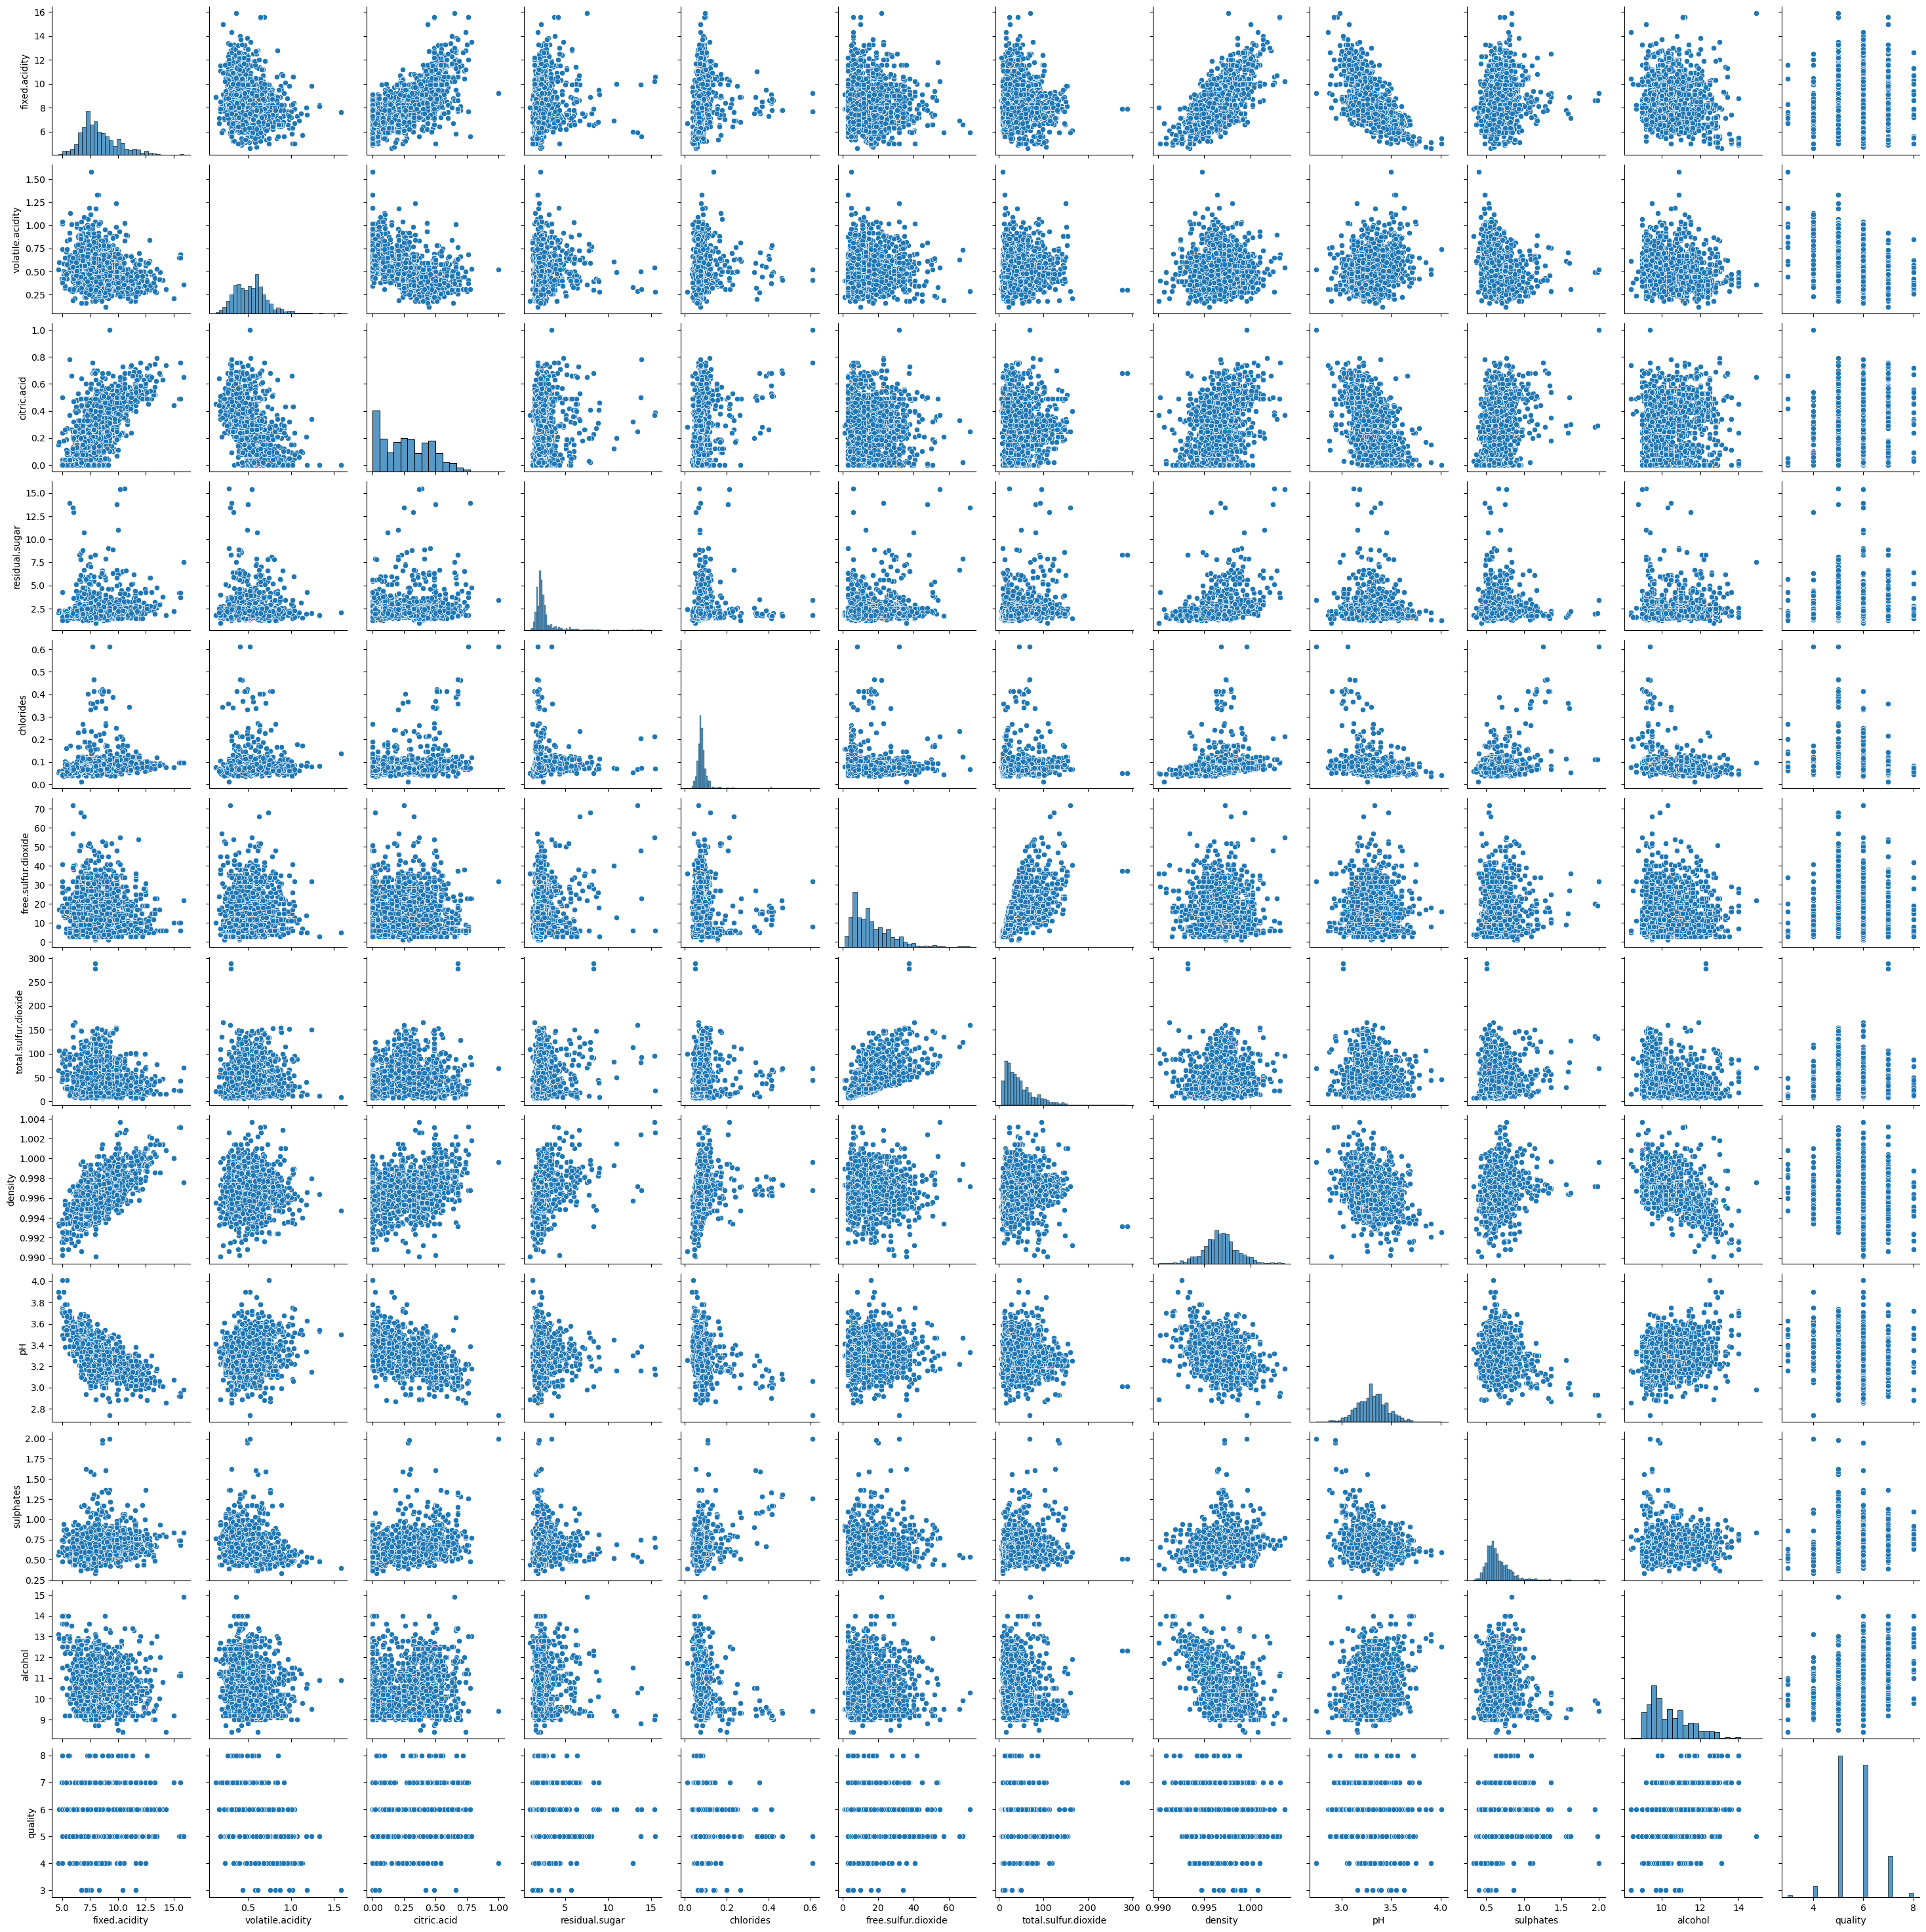

In [11]:
# Make a pairplot of the wine data
sns.pairplot(wine)


- a given cell value represents the correlation that exists between two variables 
- on the diagonal, you can see a bunch of histograms. This is because pairplotting the variables with themselves would be pointless, so the pairplot() method instead makes histograms to show the distributions of those variables' values. This allows us to quickly see the shape of each variable's values.  
- the plots for the quality variable form horizontal bands, due to the fact that it's a discrete variable. We were certainly right in not pursuing a regression analysis of this variable.
- Notice that some of the nice plots invite a line of best fit, such as alcohol vs density. Others, such as citric acid vs alcohol, are more inscrutable.

So we now have called the .corr() method, and the .pairplot() Seaborn method, on our wine data. Both have flaws. Happily, we can get the best of both worlds with a heatmap. 

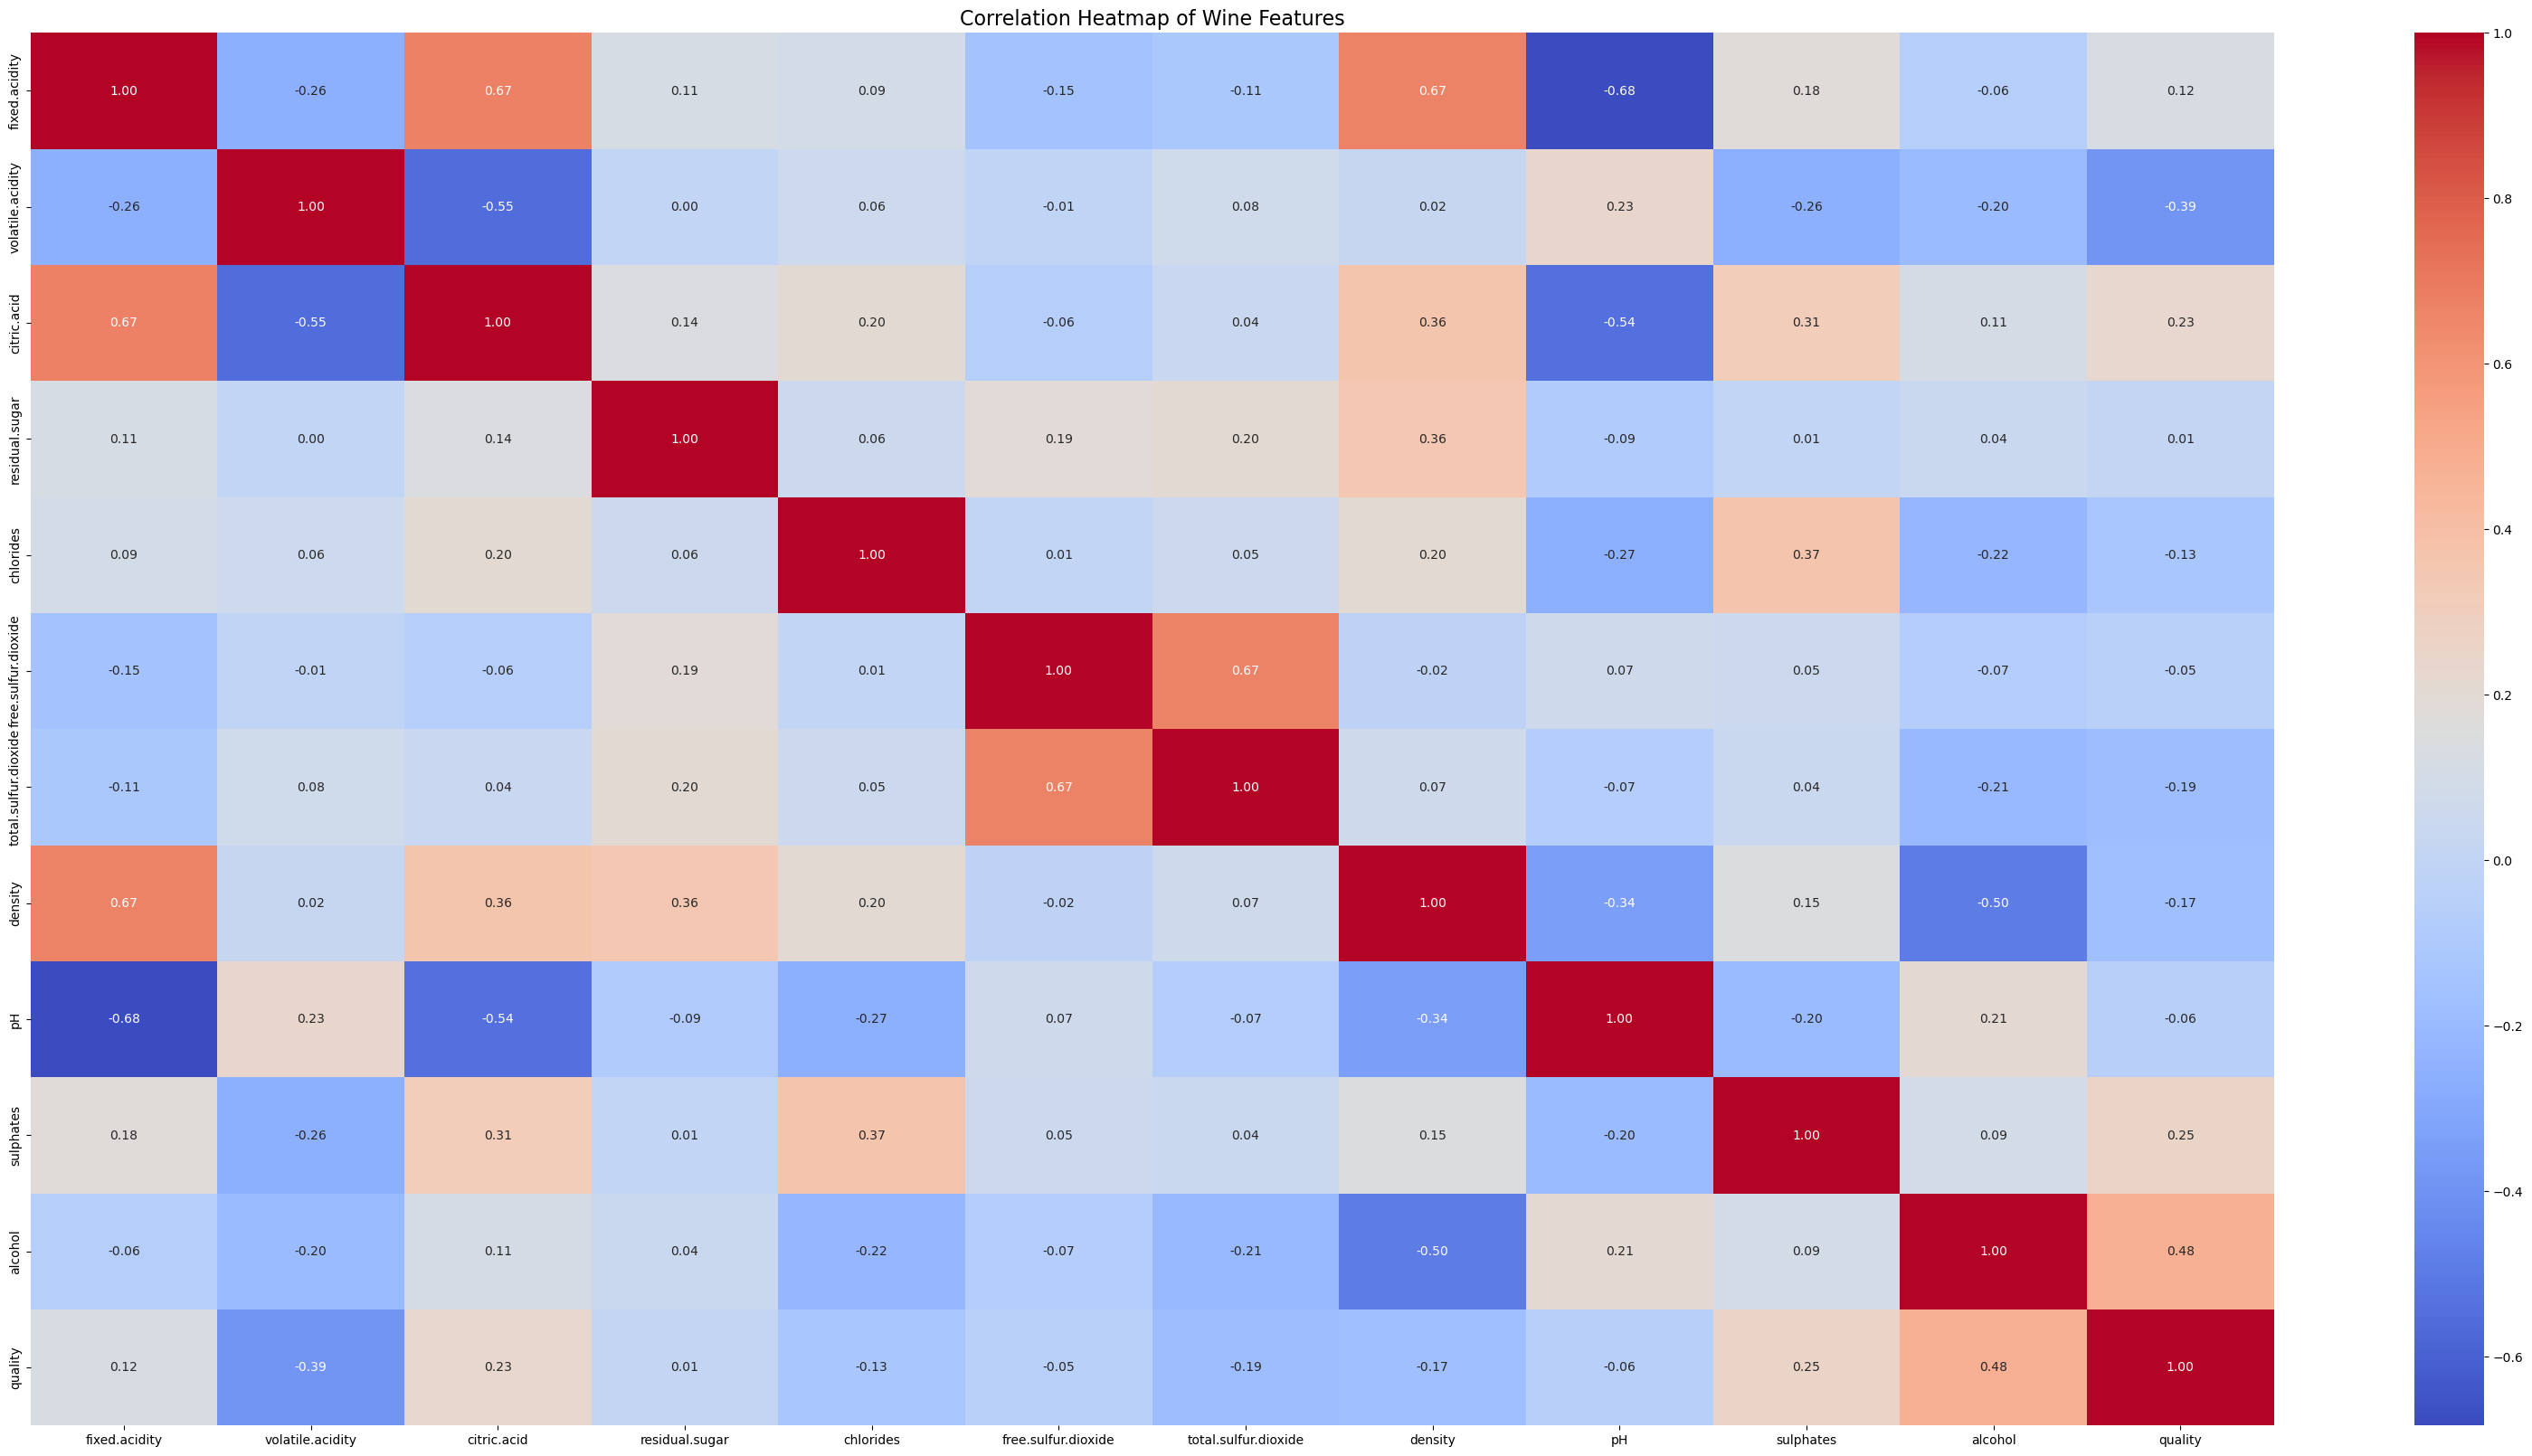

In [17]:
# We need to do some preliminary work, and ensure that the Matplotlib plot is big enough. 
# Call .figure() on plt, and plug in the parameter figsize=(40,20) (or similar suitably large dimensions)
plt.figure(figsize=(40, 20))

# To create an annotated heatmap of the correlations, we call the heatmap() method on our sns object.
# Ensure to plug in, as first parameter, wine.corr(), and as second parameter, annot=True (so the graph is annotated)
sns.heatmap(wine.corr(), annot=True,fmt=".2f",cmap="coolwarm")

plt.title("Correlation Heatmap of Wine Features", fontsize=16)
plt.show()



Color ↔ correlation: Hue gives the sign (e.g., reds = positive, blues = negative); intensity shows magnitude (deeper color = stronger |r|; pale ≈ near 0).


How to use it: Look for the deepest colors to spot pairs worth probing with scatterplots (nonlinearity/outliers), and watch for blocks of highly correlated features (possible multicollinearity).


Fixed acidity vs density: The heatmap shows a moderate-to-strong positive correlation—as fixed.acidity increases, density tends to increase.

There is a relatively strong correlation between the density and fixed acidity variables respectively. In the next code block, call the scatterplot() method on our sns object. Make the x-axis parameter 'density', the y-axis parameter 'fixed.acidity', and the third parameter specify our wine dataset.  

<Axes: xlabel='density', ylabel='fixed.acidity'>

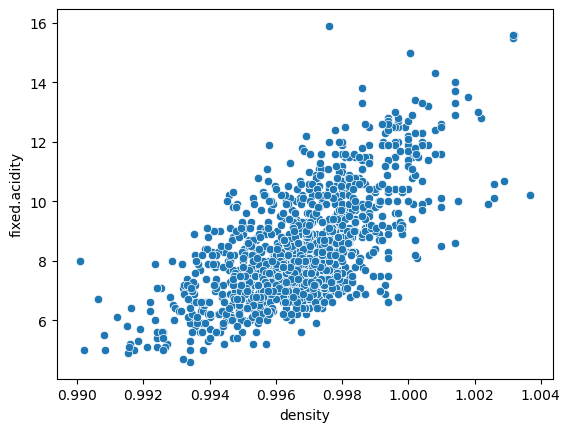

In [15]:
# Plot density against fixed.acidity
sns.scatterplot(x="density", y="fixed.acidity", data=wine)

We can see a positive correlation, and quite a steep one. There are some outliers, but as a whole, there is a steep looking line that looks like it ought to be drawn. 

<Axes: xlabel='density', ylabel='fixed.acidity'>

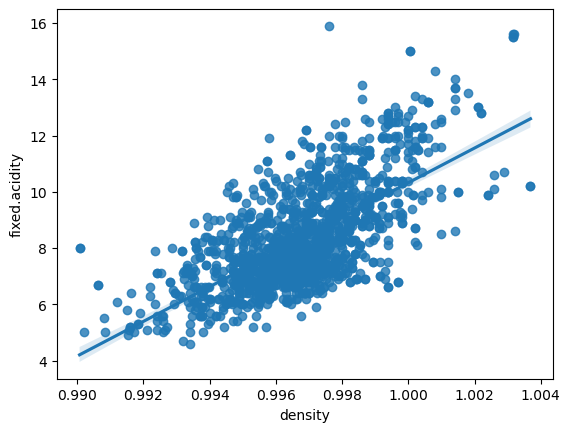

In [18]:
# Call the regplot() method on your sns object, with parameters: x = 'density', y = 'fixed.acidity',
# and data=wine, to make this correlation more clear 
sns.regplot(x="density", y='fixed.acidity', data=wine)


The line of best fit matches the overall shape of the data, but it's clear that there are some points that deviate from the line, rather than all clustering close. 

Let's see if we can predict fixed acidity based on density using linear regression. 

### 3. Modeling 

#### 3a. Train/Test Split
While this dataset is super clean, and hence doesn't require much for analysis, we still need to split our dataset into a test set and a training set.

You'll recall from p.158 of *AoS* that such a split is important good practice when evaluating statistical models. On p.158, Professor Spiegelhalter was evaluating a classification tree, but the same applies when we're doing regression. Normally, we train with 75% of the data and test on the remaining 25%. 

To be sure, for our first model, we're only going to focus on two variables: fixed acidity as our dependent variable, and density as our sole independent predictor variable. 

We'll be using [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) here. Don't worry if not all of the syntax makes sense; just follow the rationale for what we're doing. 

In [19]:
X = wine[["density"]] 
y = wine[["fixed.acidity"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [20]:
# We now want to check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1199, 1) (1199, 1)
(400, 1) (400, 1)


#### 3b. Making a Linear Regression model: our first model
Sklearn has a [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function built into the linear_model module. We'll be using that to make our regression model. 

In [23]:
# Create the model: make a variable called rModel, and assign it linear_model.LinearRegression.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

rModel = make_pipeline(StandardScaler(), LinearRegression())

In [24]:
# We now want to train the model on our test data.
rModel.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [25]:
# Evaluate the model by printing the result of calling .score() on rModel, with parameters X_train, y_train. 
print(rModel.score(X_train, y_train))

0.4548782410068146


The above score is called R-Squared coefficient, or the "coefficient of determination". It's basically a measure of how successfully our model predicts the variations in the data away from the mean: 1 would mean a perfect model that explains 100% of the variation. At the moment, our model explains only about 45% of the variation from the mean. There's more work to do!

In [26]:
# Use the model to make predictions about our test data
y_pred = rModel.predict(X_test)

Text(0, 0.5, 'predicted acidity')

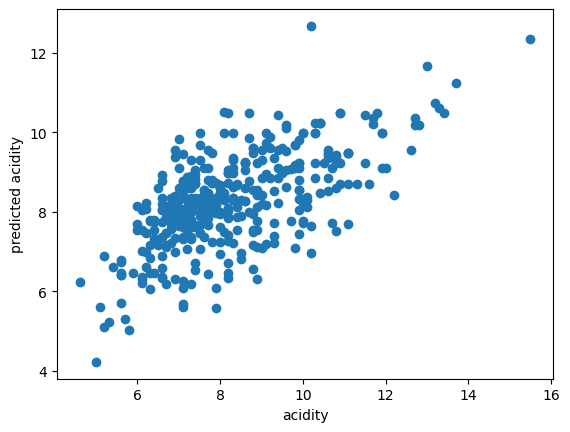

In [28]:
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(y_test,y_pred)
plt.xlabel('acidity')
plt.ylabel('predicted acidity')

The above scatterplot represents how well the predictions match the actual results. 

Along the x-axis, we have the actual fixed acidity, and along the y-axis we have the predicted value for the fixed acidity.

There is a visible positive correlation, as the model has not been totally unsuccesful, but it's clear that it is not maximally accurate: wines with an actual fixed acidity of just over 10 have been predicted as having acidity levels from about 6.3 to 13.

Let's build a similar model using a different package, to see if we get a better result that way.

#### 3c. Making a Linear Regression model: our second model: Ordinary Least Squares (OLS)

In [29]:
# Create the test and train sets. Here, we do things slightly differently.  
# We make the explanatory variable X as before.
X = wine[["density"]]


# But here, reassign X the value of adding a constant to it. This is required for Ordinary Least Squares Regression.
# Further explanation of this can be found here: 
# https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html
X = sm.add_constant(X)



In [30]:
# The rest of the preparation is as before.
y = wine["fixed.acidity"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [31]:
# Create the model
rModel2 = sm.OLS(y_train, X_train)

# Fit the model with fit() 
rModel2_results = rModel2.fit()

In [32]:
# Evaluate the model with .summary()
rModel2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed.acidity   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     998.8
Date:                Mon, 27 Oct 2025   Prob (F-statistic):          6.68e-160
Time:                        23:29:19   Log-Likelihood:                -2011.0
No. Observations:                1199   AIC:                             4026.
Df Residuals:                    1197   BIC:                             4036.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -615.7316     19.746    -31.182      0.000    -654.473    -576.990
density      626.0927     19.810     31.604      0.000     587.226     664.959
==============================================================================
Omnibus:                       94.056   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.229
Skew:                           0.668   Prob(JB):                     2.87e-27
Kurtosis:                       3.812   Cond. No.                     1.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

One of the great things about Statsmodels (sm) is that you get so much information from the summary() method. 

There are lots of values here, whose meanings you can explore at your leisure, but here's one of the most important: the R-squared score is 0.455, the same as what it was with the previous model. This makes perfect sense, right? It's the same value as the score from sklearn, because they've both used the same algorithm on the same data.

Here's a useful link you can check out if you have the time: https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/

In [33]:
# Let's use our new model to make predictions of the dependent variable y. Use predict(), and plug in X_test as the parameter
y_pred = rModel2_results.predict(X_test)

Text(0, 0.5, 'Predicted fixed acidity')

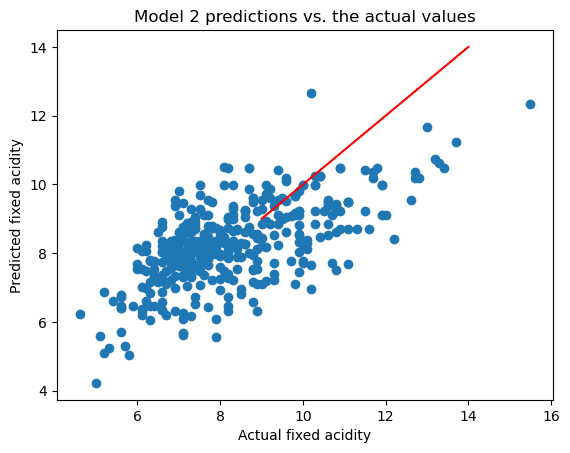

In [34]:
# Plot the predictions
# Build a scatterplot
plt.scatter(y_test, y_pred)

# Add a line for perfect correlation. Can you see what this line is doing? 
plt.plot([x for x in range(9,15)],[x for x in range(9,15)], color='red')

# Label it nicely
plt.title("Model 2 predictions vs. the actual values")
plt.xlabel("Actual fixed acidity")
plt.ylabel("Predicted fixed acidity")

The red line shows a theoretically perfect correlation between our actual and predicted values - the line that would exist if every prediction was completely correct. It's clear that while our points have a generally similar direction, they don't match the red line at all; we still have more work to do. 

To get a better predictive model, we should use more than one variable.

#### 3d. Making a Linear Regression model: our third model: multiple linear regression
Remember, as Professor Spiegelhalter explains on p.132 of *AoS*, including more than one explanatory variable into a linear regression analysis is known as ***multiple linear regression***. 

In [35]:
# Create test and train datasets
# This is again very similar, but now we include more columns in the predictors
# Include all columns from data in the explanatory variables X except fixed.acidity and quality (which was an integer)
X = wine.drop(["fixed.acidity", "quality"],axis=1)

# Create constants for X, so the model knows its bounds
X = sm.add_constant(X)
y = wine[["fixed.acidity"]]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [36]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
rModel3 = sm.OLS(y_train, X_train)
# Fit the model
rModel3_results = rModel3.fit()

In [37]:
# Evaluate the model
rModel3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed.acidity   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     804.4
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        23:35:26   Log-Likelihood:                -1145.6
No. Observations:                1199   AIC:                             2313.
Df Residuals:                    1188   BIC:                             2369.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -648.2418     15.246    -42.518      0.000    -678.154    -618.329
volatile.acidity         0.1313      0.135      0.971      0.332      -0.134       0.397
citric.acid              1.8651      0.155     11.995      0.000       1.560       2.170
residual.sugar          -0.2485      0.015    -16.589      0.000      -0.278      -0.219
chlorides               -3.6575      0.443     -8.263      0.000      -4.526      -2.789
free.sulfur.dioxide      0.0068      0.002      2.859      0.004       0.002       0.012
total.sulfur.dioxide    -0.0064      0.001     -7.966      0.000      -0.008      -0.005
density                671.0968     15.184     44.198      0.000     641.306     700.887
pH                      -5.1954      0.149    -34.792      0.000      -5.488      -4.902
sulphates               -0.8038      0.130     -6.193      0.000      -1.058      -0.549
alcohol                  0.5713      0.025     22.753      0.000       0.522       0.621
==============================================================================
Omnibus:                      155.238   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              562.315
Skew:                           0.595   Prob(JB):                    7.85e-123
Kurtosis:                       6.137   Cond. No.                     7.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-Squared score shows a big improvement - our first model predicted only around 45% of the variation, but now we are predicting 87%!

In [38]:
# Use our new model to make predictions
y_pred = rModel3_results.predict(X_test)

Text(0, 0.5, 'Predicted')

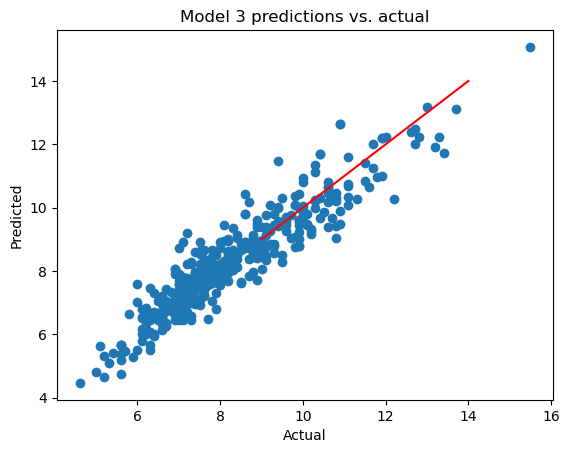

In [39]:
# Plot the predictions
# Build a scatterplot
plt.scatter(y_test, y_pred)

# Add a line for perfect correlation
plt.plot([x for x in range(9,15)],[x for x in range(9,15)], color='red')

# Label it nicely
plt.title("Model 3 predictions vs. actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

We've now got a much closer match between our data and our predictions, and we can see that the shape of the data points is much more similar to the red line. 

We can check another metric as well - the RMSE (Root Mean Squared Error). The MSE is defined by Professor Spiegelhalter on p.393 of *AoS*, and the RMSE is just the square root of that value. This is a measure of the accuracy of a regression model. Very simply put, it's formed by finding the average difference between predictions and actual values. Check out p. 163 of *AoS* for a reminder of how this works. 

In [40]:
# Define a function to check the RMSE. 
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [41]:
# Get predictions from rModel3
y_pred = rModel3_results.predict(X_test)

# Put the predictions & actual values into a dataframe
matches = pd.DataFrame(y_test)
matches.rename(columns = {'fixed.acidity':'actual'}, inplace=True)
matches["predicted"] = y_pred

rmse(matches["actual"], matches["predicted"])

np.float64(0.6163194678949014)

The RMSE tells us how far, on average, our predictions were mistaken. An RMSE of 0 would mean we were making perfect predictions. 0.6 signifies that we are, on average, about 0.6 of a unit of fixed acidity away from the correct answer. That's not bad at all.

#### 3e. Making a Linear Regression model: our fourth model: avoiding redundancy 

We can also see from our early heat map that volatile.acidity and citric.acid are both correlated with pH. We can make a model that ignores those two variables and just uses pH, in an attempt to remove redundancy from our model.

In [42]:
# Create test and train datasets
# Include the remaining six columns as predictors
X = wine[["residual.sugar","chlorides","total.sulfur.dioxide","density","pH","sulphates"]]

# Create constants for X, so the model knows its bounds
X = sm.add_constant(X)

y = wine[["fixed.acidity"]]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [43]:
# Create the fifth model
rModel4 = sm.OLS(y_train, X_train)
# Fit the model
rModel4_results = rModel4.fit()
# Evaluate the model
rModel4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed.acidity   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     571.8
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        23:37:37   Log-Likelihood:                -1562.3
No. Observations:                1199   AIC:                             3139.
Df Residuals:                    1192   BIC:                             3174.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -485.6576     16.010    -30.335      0.000    -517.068    -454.247
residual.sugar          -0.1078      0.020     -5.481      0.000      -0.146      -0.069
chlorides               -6.3544      0.578    -10.990      0.000      -7.489      -5.220
total.sulfur.dioxide    -0.0094      0.001    -11.799      0.000      -0.011      -0.008
density                516.4441     15.894     32.492      0.000     485.260     547.628
pH                      -6.0430      0.184    -32.766      0.000      -6.405      -5.681
sulphates                0.7540      0.165      4.559      0.000       0.430       1.078
==============================================================================
Omnibus:                      105.987   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.837
Skew:                           0.572   Prob(JB):                     1.22e-45
Kurtosis:                       4.683   Cond. No.                     5.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared score has reduced, showing us that actually, the removed columns were important.

### Conclusions & next steps

Here's one conclusion that seems right. While our most predictively powerful model was rModel3, this model had explanatory variables that were correlated with one another, which made some redundancy. Our most elegant and economical model was rModel4 - it used just a few predictors to get a good result. 

All of our models in this notebook have used the OLS algorithm - Ordinary Least Squares. There are many other regression algorithms, and if you have time, it would be good to investigate them. You can find some examples [here](https://www.statsmodels.org/dev/examples/index.html#regression). Be sure to make a note of what you find, and chat through it with your mentor at your next call.
